In [55]:
import numpy as np
import os
from scipy.spatial.distance import squareform, cdist, pdist
import seaborn as sns
import timecorr as tc
import hypertools as hyp
from scipy.linalg import toeplitz
%matplotlib inline

In [52]:
#results_dir = os.path.join(os.path.expanduser('~'), 'Desktop', 'synthetic_data')
#if not os.path.exists(results_dir):
#    os.makedirs(results_dir)

In [103]:
laplace_params = {'scale': 100}
def laplace_weights(T, params=laplace_params):
    absdiffs = toeplitz(np.arange(T))
    return np.multiply(np.divide(2.5, 2 * params['scale']), np.exp(-np.divide(absdiffs, params['scale']))) #scale to prevent near-zero rounding issues

In [106]:
laplace_weights(100).shape

(100, 100)

In [107]:
tc.gaussian_weights(100).shape

(100, 100)

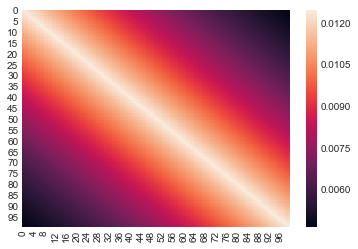

In [104]:
sns.heatmap(laplace_weights(100))

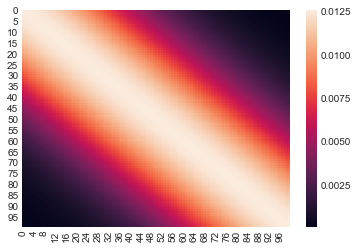

In [58]:
sns.heatmap(tc.gaussian_weights(100))

In [59]:
S = 5 #number of subjects
T = 100 #number of timepoints per event
E = 10 #number of events
K = 100 #number of features

In [60]:
def generate_random_covariance_matrix(N):
    template = np.random.randn(N, N)
    cov = np.multiply(template, template.T)
    return tc.helpers.mat2vec(cov)

In [61]:
#make a timeseries of covariance matrices
covs = np.zeros((E, int((K**2 - K)/2 + K)))
for event in np.arange(E):
    covs[event, :] = generate_random_covariance_matrix(K)

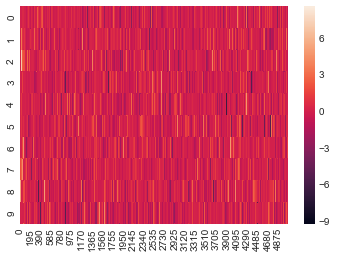

In [62]:
sns.heatmap(covs)

In [63]:
def generate_data(sq_cov, T):
    import warnings
    warnings.simplefilter('ignore')
    covmat = tc.helpers.vec2mat(sq_cov)
    return np.random.multivariate_normal(np.zeros(covmat.shape[0]), covmat, (T))

In [64]:
def generate_template_data(covs, T):
    data = []
    for i in np.arange(covs.shape[0]):
        data.extend(generate_data(covs[i, :], T))
    return np.vstack(data)

In [65]:
def generate_subject_data(template):
    noise = np.random.randn(T*E, template.shape[1])
    return np.add(template, noise)

In [66]:
template_data = generate_template_data(covs, T)
data = []
for s in np.arange(S):
    data.append(generate_subject_data(template_data))

In [67]:
#fname = os.path.join(results_dir, 'data.npz')
#np.savez(fname, data=data, S=S, T=T, E=E, K=K, covmats=covs)

In [69]:
recovered_covs_gaussian = tc.timecorr(data, mode='across')

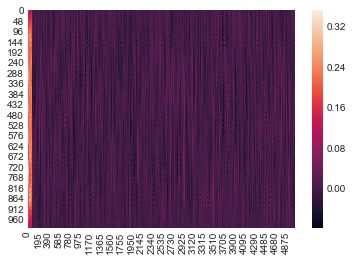

In [70]:
sns.heatmap(recovered_covs_gaussian)

In [111]:
recovered_covs_laplace = tc.timecorr(data, mode='across', weights_function=laplace_weights, weights_params=laplace_params)

ValueError: shapes (100,714) and (691,100) not aligned: 714 (dim 1) != 691 (dim 0)

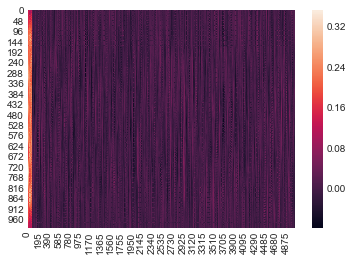

In [109]:
sns.heatmap(recovered_covs_laplace)

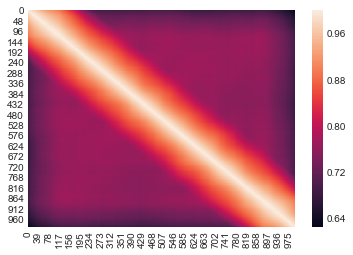

In [110]:
sns.heatmap(1 - cdist(recovered_covs_gaussian, recovered_covs_laplace, 'correlation'))

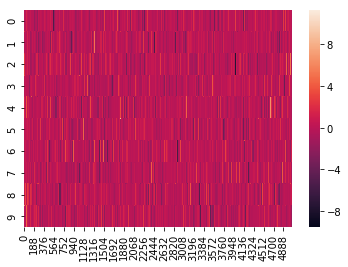

In [18]:
sns.heatmap(covs)

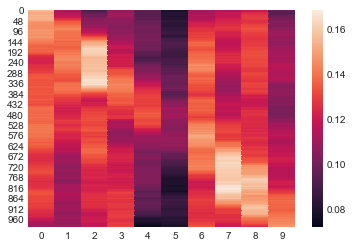

In [72]:
#this should have light spots (high correlations) along the diagonal...
sns.heatmap(1 - cdist(recovered_covs_gaussian, covs, 'correlation'))

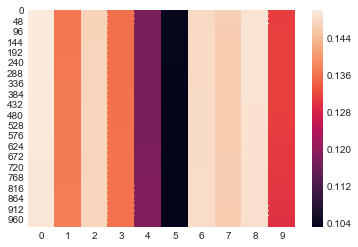

In [80]:
sns.heatmap(1 - cdist(recovered_covs_laplace, covs, 'correlation'))

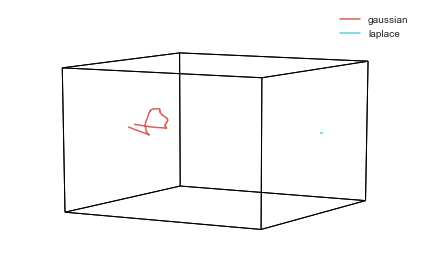

In [81]:
hyp.plot([recovered_covs_gaussian, recovered_covs_laplace], legend=['gaussian', 'laplace'])